# MLWorkbench Magics

The MLWorkbench Magics are a set of Datalab magic functions that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the cleaned data from the previous notebook and build a classification model. The data is too small to need cloud services, but the magic commands can easily be used to start cloud jobs on large datasets.

The commands in this notebook run the sample without calling ML Engine services. 

If you changed the WORKSPACE_PATH variable in the previous notebook, you must also change it here. If you made no modifications, there is no need to update the next cell. The previous notebook must be executed before this one.

In [1]:
WORKSPACE_PATH = '/content/datalab/workspace/structured_data_classification_stackoverflow'

In [2]:
import os
import csv
import re
import pandas as pd
import six
import string
import random
import numpy as np
import json

In [3]:
# Clean data 
clean_folder = os.path.join(WORKSPACE_PATH, 'clean_input')
train_data_path = os.path.join(clean_folder, 'train.csv')
eval_data_path = os.path.join(clean_folder, 'eval.csv')
schema_path = os.path.join(clean_folder, 'schema.json')
transform_path = os.path.join(clean_folder, 'transforms.json')

# For analyze step
analyze_output = os.path.join(WORKSPACE_PATH, 'analyze_output')

# For the transform step
transform_output = os.path.join(WORKSPACE_PATH, 'transform_output')
transformed_train_pattern = os.path.join(transform_output, 'features_train*')
transformed_eval_pattern = os.path.join(transform_output, 'features_eval*')

# For the training step
training_output = os.path.join(WORKSPACE_PATH, 'training_output')

# For the prediction steps
batch_predict_output = os.path.join(WORKSPACE_PATH, 'batch_predict_output')
evaluation_model = os.path.join(training_output, 'evaluation_model')
regular_model = os.path.join(training_output, 'model')

In [4]:
assert os.path.isfile(train_data_path) and os.path.isfile(eval_data_path)

In [5]:
# Load the features and schema into memory
with open(schema_path) as f:
  schema = json.loads(f.read())
  
with open(transform_path) as f:
  transforms = json.loads(f.read())

# Step 1: Analyze the csv file

The first step in the MLWorkbench workflow is to analyze the data for the requested transformations. The analyze step will compute the vocabularies for the categorical columns and related statistics for the numerical columns. These values are used during training.

In [6]:
import google.datalab.contrib.mlworkbench.commands # this loads the %%ml commands

In [7]:
%%ml analyze
output: $analyze_output
training_data:
    csv: $train_data_path
    schema: $schema
features: $transforms

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/workspace/structured_data_classification_stackoverflow/clean_input/train.csv...
file /content/datalab/workspace/structured_data_classification_stackoverflow/clean_input/train.csv analyzed.


In [8]:
!ls $analyze_output

features.json
schema.json
stats.json
vocab_AnnoyingUI.csv
vocab_AssessJobCommute.csv
vocab_AssessJobCompensation.csv
vocab_AssessJobDept.csv
vocab_AssessJobDiversity.csv
vocab_AssessJobExp.csv
vocab_AssessJobFinances.csv
vocab_AssessJobIndustry.csv
vocab_AssessJobLeaders.csv
vocab_AssessJobOffice.csv
vocab_AssessJobProduct.csv
vocab_AssessJobProfDevel.csv
vocab_AssessJobProjects.csv
vocab_AssessJobRemote.csv
vocab_AssessJobRole.csv
vocab_AssessJobTech.csv
vocab_AuditoryEnvironment.csv
vocab_BoringDetails.csv
vocab_BuildingThings.csv
vocab_ChallengeMyself.csv
vocab_ChangeWorld.csv
vocab_CheckInCode.csv
vocab_ClickyKeys.csv
vocab_CollaborateRemote.csv
vocab_CompanySize.csv
vocab_CompanyType.csv
vocab_CompetePeers.csv
vocab_Country.csv
vocab_CousinEducation.csv
vocab_Currency.csv
vocab_DeveloperType.csv
vocab_DifficultCommunication.csv
vocab_DiversityImportant.csv
vocab_EducationImportant.csv
vocab_EducationTypes.csv
vocab_EmploymentStatus.csv
vocab_EnjoyDebugging.csv
vocab_EquipmentSatis

# Step 2: Transforming the input data

This step is only required if the input data has an image path column. The transform step performs some transformations on the input data and saves the results to a special TensorFlow file called a TFRecord file containing TF.Example protocall buffers. This allows training to start from preprocessed data. If this step is not used, training would have to perform the same preprocessing on every row of csv data every time it is used. As TensorFlow reads the same data row multiple times during training, this means the same row would be preprocessed multiple times. By writing the preprocessed data to disk, we can improve training performance. 

Because the data is small, and other ML Workbench samples perform the transform step, this notebook will skip this step. Training will start from the cleaned csv files. 

However, we will still run the transformation cells below (which should take only a few minutes). As an exercise, modify the training step to use the preprocessed files!

In [9]:
!rm -r -f $transform_output

In [10]:
%%ml transform
output: $transform_output
analysis: $analyze_output
prefix: features_train
training_data:
    csv: $train_data_path

2017-07-14 21:02:28.147648: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:02:28.148000: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:02:28.148076: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:02:28.148089: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:02:28.148100: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [11]:
%%ml transform
output: $transform_output
analysis: $analyze_output
prefix: features_eval
training_data:
    csv: $eval_data_path

2017-07-14 21:06:48.557895: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:06:48.558602: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:06:48.558864: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:06:48.559106: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-14 21:06:48.559349: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

In [12]:
# Error files are written even if there are no errors.
# Check that they are empty
!wc -l $transform_output/errors*

0 /content/datalab/workspace/structured_data_classification_stackoverflow/transform_output/errors_features_eval-00000-of-00001.txt
0 /content/datalab/workspace/structured_data_classification_stackoverflow/transform_output/errors_features_train-00000-of-00001.txt
0 total


# Step 3: Training

MLWorkbench automatically builds standard TensorFlow models without you having to write any TensorFlow code. The command below starts training from the cleaned csv files.

As an exercise, run training again with the preprocessed files from the training step and note any performance differences. (Hint: there should be an improvement when using transformed files, but it will be small because the dataset is small. Model accuracy should be similar, but not guaranteed to be the same).

In [13]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!rm -fr $training_output

In [14]:
%time
%%ml train
output: $training_output
analysis: $analyze_output
training_data:
    csv: $train_data_path
evaluation_data:
    csv: $eval_data_path
model_args:
    model: dnn_classification
    hidden-layer-size1: 100
    max-steps: 5000
    top-n: 2
    save-checkpoints-secs: 60

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 60, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcd0a437710>, '_model_dir': '/content/datalab/workspace/structured_data_classification_stackoverflow/training_output/train', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope the

In [15]:
!ls

1.0 Download and clean the StackOverflow 2017 survey data.ipynb
2.0 Classification with MLWorkbench (local).ipynb


# Step 4: Evaluation using batch prediction

Below, we use the evaluation model and run batch prediction locally. Batch prediction is good for large datasets where the data cannot fit in memory or when you want to limit peak memory usage.

In [16]:
%%ml batch_predict
model: $evaluation_model
output: $batch_predict_output
format: csv
prediction_data:
  csv: $eval_data_path

local prediction...
INFO:tensorflow:Restoring parameters from /content/datalab/workspace/structured_data_classification_stackoverflow/training_output/evaluation_model/variables/variables
done.


In [17]:
!ls $batch_predict_output

predict_results_eval.csv  predict_results_schema.json


In [18]:
with open(os.path.join(batch_predict_output, 'predict_results_schema.json'), 'r') as f:
  predict_schema = json.load(f)
  
df = pd.read_csv(os.path.join(batch_predict_output, 'predict_results_eval.csv'), header=None, names=[x['name'] for x in predict_schema])
correct = sum([1 if row['predicted'] == row['target'] else 0 for index, row in df.iterrows()])
accuracy = correct / float(len(df.index))
print('accuracy = %f' % accuracy)

accuracy = 0.987151


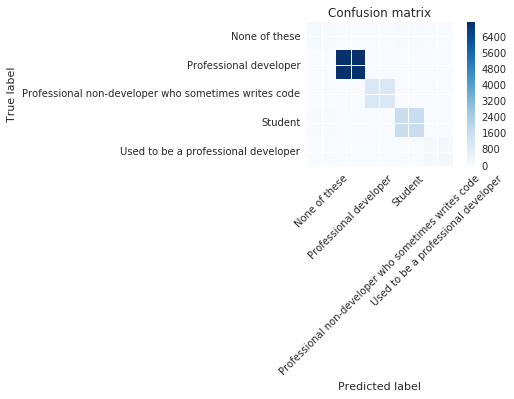

In [19]:
from google.datalab.ml import ConfusionMatrix

cm = ConfusionMatrix.from_csv(os.path.join(batch_predict_output, 'predict_results_eval.csv'), headers=[x['name'] for x in predict_schema])
cm.plot()

# Step 5: Instant prediction

The MLWorkbench also supports running prediction and displaying the results within the notebook. Note that we use the non-evaluation model below, so the target column is removed.

In [20]:
!head $eval_data_path -n 3

2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning a bachelor's degree,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,"Privately-held limited company, not in startup mode",9 to 10 years,,,,,,,,,,,,,,,,,"With a hard ""g,"" like ""gift""",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,No,Other,,Some other way,Important,Important,Important,Important,Somewhat important,Somewhat important,Not very important,Somewhat important,Not very important,Very important,British pounds sterling (),,Spaces,,Online_course Self-taught Hackathon Open_source_contributions,Official_documentation Stack_Overflow_Q&A Other,,,10:00 AM,JavaScript Python Ruby SQL,Java Python Ruby SQL,.NET_Core,.NET_Core,MySQL SQLite,MySQL SQLite,Amazon_Web_Services_(AWS),Linux_Desktop Raspberry_Pi Amazon_Web_Services_(AWS),Atom Notepad++ Vim PyCharm RubyMine Visual_Studio Visual_Studio_Code,"Put on some ambient sounds (e.g

In [21]:
headers_string = ','.join([x['name'] for x in schema if x['name'] != schema[1]['name']])

Feel free to copy the 3 rows above into the prediction list below, but don't forget to remove the target column (the 2nd column). Note that the column order must batch what was used during training.

In [22]:
%%ml predict
model: $regular_model
headers: $headers_string
prediction_data:
  - 2,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning a bachelor's degree,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,"Privately-held limited company, not in startup mode",9 to 10 years,,,,,,,,,,,,,,,,,"With a hard ""g,"" like ""gift""",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,No,Other,,Some other way,Important,Important,Important,Important,Somewhat important,Somewhat important,Not very important,Somewhat important,Not very important,Very important,British pounds sterling (),,Spaces,,Online_course Self-taught Hackathon Open_source_contributions,Official_documentation Stack_Overflow_Q&A Other,,,10:00 AM,JavaScript Python Ruby SQL,Java Python Ruby SQL,.NET_Core,.NET_Core,MySQL SQLite,MySQL SQLite,Amazon_Web_Services_(AWS),Linux_Desktop Raspberry_Pi Amazon_Web_Services_(AWS),Atom Notepad++ Vim PyCharm RubyMine Visual_Studio Visual_Studio_Code,"Put on some ambient sounds (e.g. whale songs, forest sounds)",,Git,Multiple times a day,Agree,Disagree,Strongly disagree,Agree,Somewhat agree,Disagree,Strongly disagree,Customer_satisfaction On_time/in_budget Peers'_rating Self-rating,Not very satisfied,Satisfied,Satisfied,Satisfied,Somewhat satisfied,Satisfied,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,I have created a CV or Developer Story on Stack Overflow,8.0,Desktop iOS_browser iOS_app Android_browser Android_app,Several times,Several times,Once or twice,Once or twice,Once or twice,Haven't done at all,Several times,At least once each week,Disagree,Strongly disagree,Strongly disagree,Strongly agree,Agree,Strongly agree,Strongly agree,Strongly disagree,Male,A master's degree,White_or_of_European_descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,,37500.0
  - 4,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day each week","10,000 or more employees",Non-profit/non-governmental organization or private school/university,14 to 15 years,9 to 10 years,,,,,Data_scientist,6.0,3.0,,,,,,,,,"With a soft ""g,"" like ""jiff""",Strongly agree,Strongly agree,Strongly agree,Disagree,Somewhat agree,Agree,Agree,Agree,Somewhat agree,Strongly disagree,Strongly agree,Agree,Disagree,Strongly agree,Strongly agree,Somewhat agree,Agree,I am actively looking for a job,5.0,Between 2 and 4 years ago,Somewhat important,Somewhat important,Somewhat important,Important,Important,Very important,Important,Very important,Important,Somewhat important,Not very important,Very important,Important,Very important,Very important,Stock_options Annual_bonus Health_benefits Equipment Private_office,Yes,LinkedIn Other,,"A friend, family member, or former colleague told me",Somewhat important,Somewhat important,Very important,Very important,Somewhat important,Somewhat important,Not very important,Not very important,Important,Very important,,,Spaces,,,,,,9:00 AM,Matlab Python R SQL,Matlab Python R SQL,React,Hadoop Node.js React,MongoDB Redis SQL_Server MySQL SQLite,MongoDB Redis SQL_Server MySQL SQLite,Windows_Desktop Linux_Desktop Mac_OS Amazon_Web_Services_(AWS),Windows_Desktop Linux_Desktop Mac_OS Amazon_Web_Services_(AWS),Notepad++ Sublime_Text TextMate Vim IPython_/_Jupyter NetBeans PyCharm Xcode,Turn on some music,Agile,Git,Multiple times a day,Somewhat agree,Agree,Somewhat agree,Somewhat agree,Strongly agree,Disagree,Somewhat agree,,,,,,,,,,,,,,,,,,,I have created a CV or Developer Story on Stack Overflow,10.0,Desktop iOS_browser iOS_app,At least once each week,Several times,At least once each week,Several times,At least once each week,Several times,At least once each day,At least once each day,Agree,Strongly disagree,Strongly disagree,Strongly agree,Strongly agree,Agree,Strongly agree,Disagree,Male,A doctoral degree,White_or_of_European_descent,Agree,Agree,Somewhat agree,Strongly agree,,
  - 11,"Yes, I program as a hobby",United States,No,Employed full-time,Bachelor's degree,A social science,All or almost all the time (I'm full-time remote),100 to 499 employees,Venture-funded startup,12 to 13 years,11 to 12 years,,,,,Other,8.0,9.0,,,,,,,,,"With a hard ""g,"" like ""gift""",,,,,,,,,,,,,,,,,,I am not interested in new job opportunities,,Between 1 and 2 years ago,,,,,,,,,,,,,,,,Vacation/days_off Health_benefits Professional_development_sponsorship Expected_work_hours Remote_options,No,LinkedIn Monster Other,,I visited the company's Web site and found a job listing there,Very important,Not very important,Important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Somewhat important,Very important,,,Tabs,,Online_course On-the-job_training Self-taught,Official_documentation Trade_book Stack_Overflow_Q&A,,,6:00 AM,R SQL,C# R SQL,,,SQL_Server,SQL_Server,,,Visual_Studio,Turn on some music,Agile Scrum Pair,Git,Just a few times over the year,Somewhat agree,Disagree,Strongly disagree,Agree,Agree,Disagree,Strongly agree,,,,,,,,,,,,,,,,,,,I have created a CV or Developer Story on Stack Overflow,10.0,Desktop iOS_browser iOS_app,Several times,Once or twice,Haven't done at all,Haven't done at all,Haven't done at all,Haven't done at all,Haven't done at all,At least once each week,Agree,Strongly disagree,Strongly disagree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly disagree,Female,"Some college/university study, no bachelor's degree",White_or_of_European_descent,Strongly disagree,Agree,Strongly disagree,Strongly agree,,

INFO:tensorflow:Restoring parameters from /content/datalab/workspace/structured_data_classification_stackoverflow/training_output/model/variables/variables


Respondent,predicted,predicted_2,score,score_2,AnnoyingUI,AssessJobCommute,AssessJobCompensation,AssessJobDept,AssessJobDiversity,AssessJobExp,AssessJobFinances,AssessJobIndustry,AssessJobLeaders,AssessJobOffice,AssessJobProduct,AssessJobProfDevel,AssessJobProjects,AssessJobRemote,AssessJobRole,AssessJobTech,AuditoryEnvironment,BoringDetails,BuildingThings,CareerSatisfaction,ChallengeMyself,ChangeWorld,CheckInCode,ClickyKeys,CollaborateRemote,CompanySize,CompanyType,CompetePeers,Country,CousinEducation,Currency,DeveloperType,DifficultCommunication,DiversityImportant,EducationImportant,EducationTypes,EmploymentStatus,EnjoyDebugging,EquipmentSatisfiedCPU,EquipmentSatisfiedMonitors,EquipmentSatisfiedRAM,EquipmentSatisfiedRW,EquipmentSatisfiedStorage,ExCoder10Years,ExCoderActive,ExCoderBalance,ExCoderBelonged,ExCoderNotForMe,ExCoderReturn,ExCoderSkills,ExCoderWillNotCode,ExpectedSalary,FormalEducation,FriendsDevelopers,Gender,HaveWorkedDatabase,HaveWorkedFramework,HaveWorkedLanguage,HaveWorkedPlatform,HighestEducationParents,HomeRemote,HoursPerWeek,IDE,ImportantBenefits,ImportantHiringAlgorithms,ImportantHiringCommunication,ImportantHiringCompanies,ImportantHiringEducation,ImportantHiringGettingThingsDone,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringRep,ImportantHiringTechExp,ImportantHiringTitles,InTheZone,InfluenceCloud,InfluenceCommunication,InfluenceConsultants,InfluenceDatabase,InfluenceDeptTech,InfluenceHardware,InfluenceInternet,InfluenceRecruitment,InfluenceServers,InfluenceTechStack,InfluenceVizTools,InfluenceWorkstation,InterestedAnswers,InvestTimeTools,JobProfile,JobSatisfaction,JobSecurity,JobSeekingStatus,KinshipDevelopers,LastNewJob,LearnedHiring,LearningNewTech,MajorUndergrad,Methodology,MetricAssess,MobileDeveloperType,NonDeveloperType,OtherPeoplesCode,Overpaid,ProblemSolving,ProgramHobby,ProjectManagement,PronounceGIF,QuestionsConfusing,QuestionsInteresting,Race,ResumePrompted,RightWrongWay,Salary,SelfTaughtTypes,SeriousWork,ShipIt,StackOverflowAdsDistracting,StackOverflowAdsRelevant,StackOverflowAnswer,StackOverflowBetter,StackOverflowCommunity,StackOverflowCompanyPage,StackOverflowCopiedCode,StackOverflowDescribes,StackOverflowDevices,StackOverflowFoundAnswer,StackOverflowHelpful,StackOverflowJobListing,StackOverflowJobSearch,StackOverflowMakeMoney,StackOverflowMetaChat,StackOverflowModeration,StackOverflowNewQuestion,StackOverflowSatisfaction,StackOverflowWhatDo,SurveyLong,TabsSpaces,TimeAfterBootcamp,UnderstandComputers,University,VersionControl,WantWorkDatabase,WantWorkFramework,WantWorkLanguage,WantWorkPlatform,WebDeveloperType,WorkPayCare,WorkStart,YearsCodedJob,YearsCodedJobPast,YearsProgram
2,Student,None of these,1.0,4.450710e-10,,,,,,,,,,,,,,,,,Put on some ambient sounds (e.g. whal...,,,,,,Multiple times a day,No,Strongly disagree,20 to 99 employees,"Privately-held limited company, not i...",,United Kingdom,,British pounds sterling (),,Disagree,,,Online_course Self-taught Hackathon O...,Employed part-time,Agree,Satisfied,Not very satisfied,Satisfied,Somewhat satisfied,Satisfied,,,,,,,,,37500.0,Some college/university study without...,,Male,MySQL SQLite,.NET_Core,JavaScript Python Ruby SQL,Amazon_Web_Services_(AWS),A master's degree,"More than half, but not all, the time",,Atom Notepad++ Vim PyCharm RubyMine V...,,Important,Important,Somewhat important,Somewhat important,Very important,Important,Somewhat important,Not very important,Important,Not very important,Somewhat agree,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,Satisfied,No influence at all,No influence at all,No influence at all,No influence at all,No influence at all,Strongly agree,,Other,,,,,,Some other way,,Computer science or software engineering,,Customer_satisfaction On_time/in_budg...,,,Disagree,,,"Yes, both",Strongly disagree,"With a hard ""g,"" like ""gift""",Disagree,Somewhat agree,White_or_of_European_descent,,,,Official_documentation Stack_Ov